In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# === Enable GPU memory growth ===
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled.")
    except RuntimeError as e:
        print("❌ GPU config error:", e)

# === Paths ===
metadata_path ="/content/drive/MyDrive/DermAI/balanced_metadata_binary_normalized.csv"
image_root_dir = "/content/drive/MyDrive/DermAI/balanced_two_classes"

# === Load metadata ===
df = pd.read_csv(metadata_path)
metadata_features = ['age_normalized', 'sex'] + [
    col for col in df.columns if col.startswith('binary_') and col != 'binary_label'
]
print(f"Metadata features used: {metadata_features}")
print("Label distribution:\n", df['label'].value_counts())

# === Split data ===
image_ids = df['image_id'].values
labels = df['label'].values
train_ids, test_val_ids = train_test_split(image_ids, test_size=0.3, random_state=42, stratify=labels)
val_ids, test_ids = train_test_split(test_val_ids, test_size=0.5, random_state=42)
train_df = df[df['image_id'].isin(train_ids)]
val_df = df[df['image_id'].isin(val_ids)]
test_df = df[df['image_id'].isin(test_ids)]
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")

# === Image Preprocessing ===
IMG_SIZE = 380

@tf.function
def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img / 255.0

def get_image_path(image_id):
    for class_folder in os.listdir(image_root_dir):
        img_path = os.path.join(image_root_dir, class_folder, image_id + ".jpg")
        if tf.io.gfile.exists(img_path):
            return img_path
    raise FileNotFoundError(f"Image {image_id}.jpg not found.")

# === Dataset Creation ===
def create_dataset(dataframe, batch_size=10, shuffle=False):
    image_ids = dataframe['image_id'].values
    labels = dataframe['label'].values
    metadata = dataframe[metadata_features].values.astype(np.float32)

    def gen():
        for i in range(len(image_ids)):
            img_path = get_image_path(image_ids[i])
            img = preprocess_image(tf.convert_to_tensor(img_path))
            meta = tf.convert_to_tensor(metadata[i], dtype=tf.float32)
            label = tf.convert_to_tensor(labels[i], dtype=tf.float32)
            yield (img, meta), label

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            (tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
             tf.TensorSpec(shape=(len(metadata_features),), dtype=tf.float32)),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )

    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(dataframe), 1000))

    return ds.batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

batch_size = 10
train_ds = create_dataset(train_df, batch_size=batch_size, shuffle=True)
val_ds = create_dataset(val_df, batch_size=batch_size, shuffle=False)
test_ds = create_dataset(test_df, batch_size=batch_size, shuffle=False)
print("✅ Datasets are ready for training!")

from sklearn.utils.class_weight import compute_class_weight
labels_array = df['label'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=labels_array)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

resume_model_path = "/content/drive/MyDrive/DermAI/best_model_b4_binary_resume.keras"
model = load_model(resume_model_path)
print("✅ Model loaded from checkpoint at epoch 3")

trainable_count = 0
for layer in reversed(model.layers):
    if hasattr(layer, 'trainable'):
        if trainable_count < 50:
            layer.trainable = True
            trainable_count += 1
        else:
            layer.trainable = False
print(f"✅ Top {trainable_count} layers set to trainable")

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

finetuned_model_path = "/content/drive/MyDrive/DermAI/best_model_b4_binary_finetuned.keras"
checkpoint_cb = ModelCheckpoint(filepath=finetuned_model_path, monitor="val_auc", mode="max", save_best_only=True, verbose=1)
earlystop_cb = EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True, verbose=1)
lr_cb = ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-7, verbose=1)
callbacks = [checkpoint_cb, earlystop_cb, lr_cb]

train_ds = create_dataset(train_df, batch_size=batch_size, shuffle=False).repeat()
val_ds = create_dataset(val_df, batch_size=batch_size, shuffle=False).repeat()
steps_per_epoch = int(np.ceil(len(train_df) / batch_size))
validation_steps = int(np.ceil(len(val_df) / batch_size))

try:
    history = model.fit(
        train_ds,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=validation_steps,
        epochs=20,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    print(f"✅ Training resumed with top 50 layers unfrozen and best fine-tuned model saved to {finetuned_model_path}")
except Exception as e:
    print("⚠️ Training interrupted:", e)


✅ GPU memory growth enabled.
Metadata features used: ['age_normalized', 'sex', 'binary_abdomen', 'binary_acral', 'binary_back', 'binary_chest', 'binary_ear', 'binary_face', 'binary_foot', 'binary_genital', 'binary_hand', 'binary_lower_extremity', 'binary_neck', 'binary_scalp', 'binary_trunk', 'binary_unknown', 'binary_upper_extremity']
Label distribution:
 label
0    7996
1    3998
Name: count, dtype: int64
Train samples: 8395, Val samples: 1799, Test samples: 1800
✅ Datasets are ready for training!
Class weights: {0: np.float64(0.75), 1: np.float64(1.5)}
✅ Model loaded from checkpoint at epoch 3
✅ Top 50 layers set to trainable
Epoch 1/20
840/840 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6996 - auc: 0.7648 - loss: 0.5832 - precision: 0.5421 - recall: 0.6991
Epoch 1: val_auc improved from -inf to 0.79899, saving model to /content/drive/MyDrive/DermAI/best_model_b4_binary_finetuned.keras
840/840 ━━━━━━━━━━━━━━━━━━━━ 3962s 5s/step - accuracy: 0.6996 - auc: 0.7648 - loss: 0.5832 - pre

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# === Enable GPU memory growth ===
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled.")
    except RuntimeError as e:
        print("❌ GPU config error:", e)

# === Paths ===
metadata_path = "/content/drive/MyDrive/DermAI/balanced_metadata_binary_normalized.csv"
image_root_dir = "/content/drive/MyDrive/DermAI/balanced_two_classes"

# === Load metadata ===
df = pd.read_csv(metadata_path)
metadata_features = ['age_normalized', 'sex'] + [
    col for col in df.columns if col.startswith('binary_') and col != 'binary_label']
print(f"Metadata features used: {metadata_features}")
print("Label distribution:\n", df['label'].value_counts())

# === Split data ===
image_ids = df['image_id'].values
labels = df['label'].values
train_ids, test_val_ids = train_test_split(image_ids, test_size=0.3, random_state=42, stratify=labels)
val_ids, test_ids = train_test_split(test_val_ids, test_size=0.5, random_state=42)
train_df = df[df['image_id'].isin(train_ids)]
val_df = df[df['image_id'].isin(val_ids)]
test_df = df[df['image_id'].isin(test_ids)]
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")

# === Image Preprocessing ===
IMG_SIZE = 380

@tf.function
def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img / 255.0

def get_image_path(image_id):
    for class_folder in os.listdir(image_root_dir):
        img_path = os.path.join(image_root_dir, class_folder, image_id + ".jpg")
        if tf.io.gfile.exists(img_path):
            return img_path
    raise FileNotFoundError(f"Image {image_id}.jpg not found.")

# === Dataset Creation ===
def create_dataset(dataframe, batch_size=10, shuffle=False):
    image_ids = dataframe['image_id'].values
    labels = dataframe['label'].values
    metadata = dataframe[metadata_features].values.astype(np.float32)

    def gen():
        for i in range(len(image_ids)):
            img_path = get_image_path(image_ids[i])
            img = preprocess_image(tf.convert_to_tensor(img_path))
            meta = tf.convert_to_tensor(metadata[i], dtype=tf.float32)
            label = tf.convert_to_tensor(labels[i], dtype=tf.float32)
            yield (img, meta), label

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            (tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
             tf.TensorSpec(shape=(len(metadata_features),), dtype=tf.float32)),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )

    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(dataframe), 1000))

    return ds.batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

batch_size = 10
train_ds = create_dataset(train_df, batch_size=batch_size, shuffle=True)
val_ds = create_dataset(val_df, batch_size=batch_size, shuffle=False)
test_ds = create_dataset(test_df, batch_size=batch_size, shuffle=False)
print("✅ Datasets are ready for training!")

# === Class Weights ===
from sklearn.utils.class_weight import compute_class_weight
labels_array = df['label'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=labels_array)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)

# === Load model and unfreeze new set of 30 mid-layers ===
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

resume_model_path = "/content/drive/MyDrive/DermAI/best_model_b4_binary_resume.keras"
model = load_model(resume_model_path)
print("✅ Model loaded from checkpoint at epoch 3")

# Freeze all layers initially
for layer in model.layers:
    if hasattr(layer, 'trainable'):
        layer.trainable = False

# Select 30 middle layers (e.g., 40 to 70)
mid_start, mid_end = 40, 70
mid_layers = [layer for layer in model.layers if hasattr(layer, 'trainable')]

for i in range(mid_start, min(mid_end, len(mid_layers))):
    mid_layers[i].trainable = True

print(f"✅ Layers {mid_start} to {mid_end} unfrozen for fine-tuning")

# === Compile model ===
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

# === Callbacks ===
finetuned_model_path = "/content/drive/MyDrive/DermAI/best_model_b4_binary_finetuned_midlayers1.keras"
checkpoint_cb = ModelCheckpoint(filepath=finetuned_model_path, monitor="val_auc", mode="max", save_best_only=True, verbose=1)
earlystop_cb = EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True, verbose=1)
lr_cb = ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-7, verbose=1)
callbacks = [checkpoint_cb, earlystop_cb, lr_cb]

# === Prepare repeated datasets ===
train_ds = create_dataset(train_df, batch_size=batch_size, shuffle=False).repeat()
val_ds = create_dataset(val_df, batch_size=batch_size, shuffle=False).repeat()
steps_per_epoch = int(np.ceil(len(train_df) / batch_size))
validation_steps = int(np.ceil(len(val_df) / batch_size))

# === Train model ===
try:
    history = model.fit(
        train_ds,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=validation_steps,
        epochs=20,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    print(f"✅ Training resumed with middle 30 layers unfrozen and model saved to {finetuned_model_path}")
except Exception as e:
    print("⚠️ Training interrupted:", e)


❌ GPU config error: Physical devices cannot be modified after being initialized
Metadata features used: ['age_normalized', 'sex', 'binary_abdomen', 'binary_acral', 'binary_back', 'binary_chest', 'binary_ear', 'binary_face', 'binary_foot', 'binary_genital', 'binary_hand', 'binary_lower_extremity', 'binary_neck', 'binary_scalp', 'binary_trunk', 'binary_unknown', 'binary_upper_extremity']
Label distribution:
 label
0    7996
1    3998
Name: count, dtype: int64
Train samples: 8395, Val samples: 1799, Test samples: 1800
✅ Datasets are ready for training!
Class weights: {0: np.float64(0.75), 1: np.float64(1.5)}
✅ Model loaded from checkpoint at epoch 3
✅ Layers 40 to 70 unfrozen for fine-tuning
Epoch 1/20
840/840 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6775 - auc: 0.5832 - loss: 1.8343 - precision: 0.5886 - recall: 0.1312
Epoch 1: val_auc improved from -inf to 0.71689, saving model to /content/drive/MyDrive/DermAI/best_model_b4_binary_finetuned_midlayers1.keras
840/840 ━━━━━━━━━━━━━━━━

In [ ]:
# === Final Training Script for EfficientNetB4 (Binary Classification) ===

import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.losses import BinaryFocalCrossentropy

# ✅ Clear previous sessions
tf.keras.backend.clear_session()

# ✅ Enable GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled.")
    except RuntimeError as e:
        print("❌ GPU config error:", e)

# ✅ Check GPU status
!nvidia-smi
!cat /proc/meminfo | grep Mem

# === Paths ===
metadata_path = "/content/drive/MyDrive/DermAI/balanced_metadata_binary_normalized.csv"
image_root_dir = "/content/drive/MyDrive/DermAI/balanced_two_classes"
resume_model_path = "/content/drive/MyDrive/DermAI/best_model_b4_binary_finetuned_midlayers1.keras"
final_model_path = "/content/drive/MyDrive/DermAI/best_model_b4_final.keras"

# === Load metadata ===
df = pd.read_csv(metadata_path)
metadata_features = ['age_normalized', 'sex'] + [
    col for col in df.columns if col.startswith('binary_') and col != 'binary_label']
print(f"Metadata features used: {metadata_features}")
print("Label distribution:\n", df['label'].value_counts())

# === Train/Val/Test Split using StratifiedShuffleSplit ===
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_idx, test_val_idx in splitter.split(df['image_id'], df['label']):
    train_df = df.iloc[train_idx].reset_index(drop=True)
    test_val_df = df.iloc[test_val_idx].reset_index(drop=True)

splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_idx, test_idx in splitter2.split(test_val_df['image_id'], test_val_df['label']):
    val_df = test_val_df.iloc[val_idx].reset_index(drop=True)
    test_df = test_val_df.iloc[test_idx].reset_index(drop=True)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# === Image Preprocessing ===
IMG_SIZE = 380

def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img / 255.0

def get_image_path(image_id):
    for class_folder in os.listdir(image_root_dir):
        img_path = os.path.join(image_root_dir, class_folder, image_id + ".jpg")
        if tf.io.gfile.exists(img_path):
            return img_path
    raise FileNotFoundError(f"Image {image_id}.jpg not found.")

def create_dataset(dataframe, batch_size=16, shuffle=False):
    image_ids = dataframe['image_id'].values
    labels = dataframe['label'].values
    metadata = dataframe[metadata_features].values.astype(np.float32)

    def gen():
        for i in range(len(image_ids)):
            img_path = get_image_path(image_ids[i])
            img = preprocess_image(tf.convert_to_tensor(img_path))
            meta = tf.convert_to_tensor(metadata[i], dtype=tf.float32)
            label = tf.convert_to_tensor(labels[i], dtype=tf.float32)
            yield (img, meta), label

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            (tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
             tf.TensorSpec(shape=(len(metadata_features),), dtype=tf.float32)),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(dataframe), 1000))

    return ds.batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)

# === Dataset Creation ===
batch_size = 16
train_ds = create_dataset(train_df, batch_size=batch_size, shuffle=True)
val_ds = create_dataset(val_df, batch_size=batch_size)
test_ds = create_dataset(test_df, batch_size=batch_size)
print("✅ Datasets ready")

# === Class Weights ===
labels_array = df['label'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=labels_array)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)

# === Load Model ===
model = load_model(resume_model_path)
print("✅ Model loaded from:", resume_model_path)

# ✅ Freeze all layers first
for layer in model.layers:
    if hasattr(layer, 'trainable'):
        layer.trainable = False

# ✅ Unfreeze layers from index 50 onwards
trainable_layers = [layer for layer in model.layers if hasattr(layer, 'trainable')]
for i in range(50, len(trainable_layers)):
    trainable_layers[i].trainable = True
print(f"✅ Unfroze {len(trainable_layers) - 50} layers starting from index 50")

# ✅ Compile model with focal loss
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=BinaryFocalCrossentropy(gamma=2),
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# ✅ Callbacks - now monitoring recall for clinical safety
checkpoint_cb = ModelCheckpoint(filepath=final_model_path, monitor="val_recall", mode="max", save_best_only=True, verbose=1)
earlystop_cb = EarlyStopping(monitor="val_recall", mode="max", patience=5, restore_best_weights=True, verbose=1)
lr_cb = ReduceLROnPlateau(monitor="val_recall", mode="max", factor=0.5, patience=2, min_lr=1e-7, verbose=1)
callbacks = [checkpoint_cb, earlystop_cb, lr_cb]

# === Train Model ===
steps_per_epoch = int(np.ceil(len(train_df) / batch_size))
validation_steps = int(np.ceil(len(val_df) / batch_size))

!nvidia-smi
!cat /proc/meminfo | grep Mem

history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print(f"✅ Training complete. Best model saved to: {final_model_path}")


✅ GPU memory growth enabled.
Wed Jun 18 13:57:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------

In [2]:
# === Final Training Script for EfficientNetB4 (Binary Classification) ===

import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.losses import BinaryFocalCrossentropy

# ✅ Clear previous sessions
tf.keras.backend.clear_session()

# ✅ Enable GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled.")
    except RuntimeError as e:
        print("❌ GPU config error:", e)

# ✅ Check GPU status
!nvidia-smi
!cat /proc/meminfo | grep Mem

# === Paths ===
metadata_path = "/content/drive/MyDrive/DermAI/balanced_metadata_binary_normalized.csv"
image_root_dir = "/content/drive/MyDrive/DermAI/balanced_two_classes"
resume_model_path = "/content/drive/MyDrive/DermAI/best_model_b4_final.keras"
final_model_path = "/content/drive/MyDrive/DermAI/best_model_b4_final1.keras"

# === Load metadata ===
df = pd.read_csv(metadata_path)
metadata_features = ['age_normalized', 'sex'] + [
    col for col in df.columns if col.startswith('binary_') and col != 'binary_label']
print(f"Metadata features used: {metadata_features}")
print("Label distribution:\n", df['label'].value_counts())

# === Train/Val/Test Split using StratifiedShuffleSplit ===
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_idx, test_val_idx in splitter.split(df['image_id'], df['label']):
    train_df = df.iloc[train_idx].reset_index(drop=True)
    test_val_df = df.iloc[test_val_idx].reset_index(drop=True)

splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_idx, test_idx in splitter2.split(test_val_df['image_id'], test_val_df['label']):
    val_df = test_val_df.iloc[val_idx].reset_index(drop=True)
    test_df = test_val_df.iloc[test_idx].reset_index(drop=True)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# === Image Preprocessing ===
IMG_SIZE = 380

def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img / 255.0

def get_image_path(image_id):
    for class_folder in os.listdir(image_root_dir):
        img_path = os.path.join(image_root_dir, class_folder, image_id + ".jpg")
        if tf.io.gfile.exists(img_path):
            return img_path
    raise FileNotFoundError(f"Image {image_id}.jpg not found.")

def create_dataset(dataframe, batch_size=16, shuffle=False):
    image_ids = dataframe['image_id'].values
    labels = dataframe['label'].values
    metadata = dataframe[metadata_features].values.astype(np.float32)

    def gen():
        for i in range(len(image_ids)):
            img_path = get_image_path(image_ids[i])
            img = preprocess_image(tf.convert_to_tensor(img_path))
            meta = tf.convert_to_tensor(metadata[i], dtype=tf.float32)
            label = tf.convert_to_tensor(labels[i], dtype=tf.float32)
            yield (img, meta), label

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            (tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
             tf.TensorSpec(shape=(len(metadata_features),), dtype=tf.float32)),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(dataframe), 1000))

    return ds.batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)

# === Dataset Creation ===
batch_size = 16
train_ds = create_dataset(train_df, batch_size=batch_size, shuffle=True)
val_ds = create_dataset(val_df, batch_size=batch_size)
test_ds = create_dataset(test_df, batch_size=batch_size)
print("✅ Datasets ready")

# === Class Weights ===
labels_array = df['label'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=labels_array)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)

# === Load Model ===
model = load_model(resume_model_path)
print("✅ Model loaded from:", resume_model_path)

# ✅ Freeze all layers first
for layer in model.layers:
    if hasattr(layer, 'trainable'):
        layer.trainable = False

# ✅ Unfreeze layers from index 50 onwards
trainable_layers = [layer for layer in model.layers if hasattr(layer, 'trainable')]
for i in range(50, len(trainable_layers)):
    trainable_layers[i].trainable = True
print(f"✅ Unfroze {len(trainable_layers) - 50} layers starting from index 50")

# ✅ Compile model with focal loss
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=BinaryFocalCrossentropy(gamma=2),
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# ✅ Callbacks - now monitoring recall for clinical safety
checkpoint_cb = ModelCheckpoint(filepath=final_model_path, monitor="val_recall", mode="max", save_best_only=True, verbose=1)
earlystop_cb = EarlyStopping(monitor="val_recall", mode="max", patience=5, restore_best_weights=True, verbose=1)
lr_cb = ReduceLROnPlateau(monitor="val_recall", mode="max", factor=0.5, patience=2, min_lr=1e-7, verbose=1)
callbacks = [checkpoint_cb, earlystop_cb, lr_cb]

# === Train Model ===
steps_per_epoch = int(np.ceil(len(train_df) / batch_size))
validation_steps = int(np.ceil(len(val_df) / batch_size))

!nvidia-smi
!cat /proc/meminfo | grep Mem

history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    epochs=15,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print(f"✅ Training complete. Best model saved to: {final_model_path}")


✅ GPU memory growth enabled.
Thu Jun 19 08:46:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------

In [6]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# === Paths ===
metadata_path = "/content/drive/MyDrive/DermAI/balanced_metadata_binary_normalized.csv"
image_root_dir = "/content/drive/MyDrive/DermAI/balanced_two_classes"
model_path = "/content/drive/MyDrive/DermAI/best_model_b4_final1.keras"

# === Image Size and Metadata Columns ===
IMG_SIZE = 380
df = pd.read_csv(metadata_path)
metadata_features = ['age_normalized', 'sex'] + [
    col for col in df.columns if col.startswith('binary_') and col != 'binary_label']


In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_idx, test_val_idx in splitter.split(df['image_id'], df['label']):
    test_val_df = df.iloc[test_val_idx].reset_index(drop=True)

splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_idx, test_idx in splitter2.split(test_val_df['image_id'], test_val_df['label']):
    test_df = test_val_df.iloc[test_idx].reset_index(drop=True)

print("Test size:", len(test_df))


Test size: 1800


In [8]:
def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img / 255.0

def get_image_path(image_id):
    for class_folder in os.listdir(image_root_dir):
        path = os.path.join(image_root_dir, class_folder, image_id + ".jpg")
        if tf.io.gfile.exists(path):
            return path
    raise FileNotFoundError(f"Image {image_id}.jpg not found.")

def create_test_dataset(dataframe, batch_size=16):
    image_ids = dataframe['image_id'].values
    labels = dataframe['label'].values
    metadata = dataframe[metadata_features].values.astype(np.float32)

    def gen():
        for i in range(len(image_ids)):
            img_path = get_image_path(image_ids[i])
            img = preprocess_image(tf.convert_to_tensor(img_path))
            meta = tf.convert_to_tensor(metadata[i], dtype=tf.float32)
            label = tf.convert_to_tensor(labels[i], dtype=tf.float32)
            yield (img, meta), label

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            (tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
             tf.TensorSpec(shape=(len(metadata_features),), dtype=tf.float32)),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = create_test_dataset(test_df, batch_size=16)


In [ ]:
from tqdm import tqdm  # If not installed: pip install tqdm

# Reload test dataset (if needed)
# Make sure `.repeat()` is NOT used in your test dataset creation
test_ds = create_test_dataset(test_df, batch_size=16)  # no .repeat()

# Load model
model = tf.keras.models.load_model(model_path)

# === Setup for progress tracking ===
num_test_samples = len(test_df)
batch_size = 16
steps = int(np.ceil(num_test_samples / batch_size))

y_true = []
y_pred_probs = []

# Predict with tqdm progress bar
for i, ((img_batch, meta_batch), label_batch) in enumerate(tqdm(test_ds, total=steps)):
    probs = model.predict([img_batch, meta_batch], verbose=0)
    y_pred_probs.extend(probs.squeeze().tolist())
    y_true.extend(label_batch.numpy().tolist())

    # Break after full test set is processed
    if (i + 1) >= steps:
        break

# Final conversion
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = (y_pred_probs > 0.5).astype(int)


  3%|▎         | 3/113 [07:06<4:20:41, 142.19s/it]

In [ ]:
# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# ROC AUC
auc = roc_auc_score(y_true, y_pred_probs)
print(f"ROC AUC Score: {auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Test size: 500


 94%|█████████▍| 15/16 [51:58<03:27, 207.88s/it]



Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.80      0.88       337
   Malignant       0.70      0.95      0.81       163

    accuracy                           0.85       500
   macro avg       0.83      0.88      0.84       500
weighted avg       0.88      0.85      0.85       500


Confusion Matrix:
[[270  67]
 [  8 155]]

ROC AUC Score: 0.9243


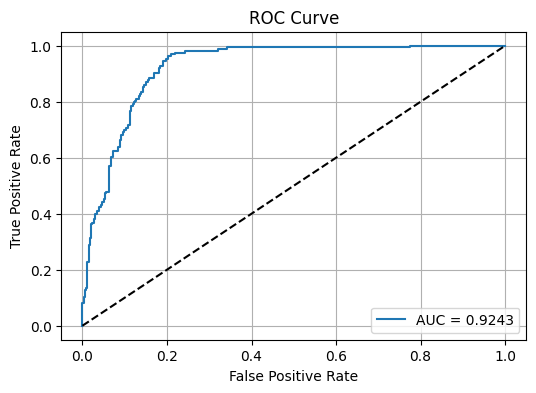

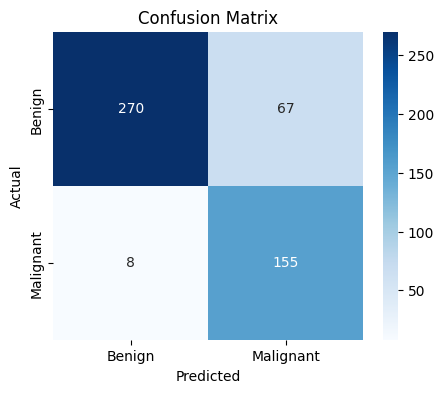

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit

# === Config ===
IMG_SIZE = 380  # ✅ Must match the model input size
BATCH_SIZE = 32
MAX_TEST_SAMPLES = 500  # Speed-up for CPU evaluation

# === Paths ===
metadata_path = "/content/drive/MyDrive/DermAI/balanced_metadata_binary_normalized.csv"
image_root_dir = "/content/drive/MyDrive/DermAI/balanced_two_classes"
model_path = "/content/drive/MyDrive/DermAI/best_model_b4_final1.keras"

# === Load Data and Metadata Features ===
df = pd.read_csv(metadata_path)
metadata_features = ['age_normalized', 'sex'] + [
    col for col in df.columns if col.startswith('binary_') and col != 'binary_label']

# === Stratified Split for Test Data ===
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_idx, test_val_idx in splitter.split(df['image_id'], df['label']):
    test_val_df = df.iloc[test_val_idx].reset_index(drop=True)

splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_idx, test_idx in splitter2.split(test_val_df['image_id'], test_val_df['label']):
    test_df = test_val_df.iloc[test_idx].reset_index(drop=True)

# === Optionally reduce test size for faster evaluation ===
if len(test_df) > MAX_TEST_SAMPLES:
    test_df = test_df.sample(MAX_TEST_SAMPLES, random_state=42).reset_index(drop=True)

print("Test size:", len(test_df))

# === Image and Metadata Preprocessing ===
def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img / 255.0

def get_image_path(image_id):
    for class_folder in os.listdir(image_root_dir):
        path = os.path.join(image_root_dir, class_folder, image_id + ".jpg")
        if tf.io.gfile.exists(path):
            return path
    raise FileNotFoundError(f"Image {image_id}.jpg not found.")

def create_test_dataset(dataframe, batch_size=BATCH_SIZE):
    image_ids = dataframe['image_id'].values
    labels = dataframe['label'].values
    metadata = dataframe[metadata_features].values.astype(np.float32)

    def gen():
        for i in range(len(image_ids)):
            img_path = get_image_path(image_ids[i])
            img = preprocess_image(tf.convert_to_tensor(img_path))
            meta = tf.convert_to_tensor(metadata[i], dtype=tf.float32)
            label = tf.convert_to_tensor(labels[i], dtype=tf.float32)
            yield (img, meta), label

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            (tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
             tf.TensorSpec(shape=(len(metadata_features),), dtype=tf.float32)),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# === Load Model and Dataset ===
test_ds = create_test_dataset(test_df)
model = tf.keras.models.load_model(model_path)

# === Prediction with Progress Bar ===
num_test_samples = len(test_df)
steps = int(np.ceil(num_test_samples / BATCH_SIZE))

y_true = []
y_pred_probs = []

for i, ((img_batch, meta_batch), label_batch) in enumerate(tqdm(test_ds, total=steps)):
    probs = model.predict([img_batch, meta_batch], verbose=0)
    y_pred_probs.extend(probs.squeeze().tolist())
    y_true.extend(label_batch.numpy().tolist())
    if (i + 1) >= steps:
        break

# === Convert and Evaluate ===
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = (y_pred_probs > 0.5).astype(int)

# === Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))

# === Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# === ROC AUC
auc = roc_auc_score(y_true, y_pred_probs)
print(f"\nROC AUC Score: {auc:.4f}")

# === ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()

# === Confusion Matrix Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
